In [1]:
# Importing dependencies
%matplotlib inline  
import os
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Is gpu available?
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


In [3]:
# Initializing VAE
from vae import Encoder, Decoder, VAE

encoder = Encoder()
decoder = Decoder()

vae = VAE(encoder, decoder)
vae.to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=1024, out_features=32, bias=True)
    )
    (logvar): Sequential(
      (0): Linear(in_features=1024, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (dense): Sequential(
      (0): Linear(in_features=32, out_features=1024, bias=True)
    )
    (deconv1): Sequential(
      (0): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
      (1): ReLU()
    )
    (deconv2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))


In [4]:
# Encoder Output
from torchsummary import summary
summary(encoder, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           1,568
              ReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
              ReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
              ReLU-8            [-1, 256, 2, 2]               0
            Linear-9                   [-1, 32]          32,800
           Linear-10                   [-1, 32]          32,800
Total params: 755,744
Trainable params: 755,744
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.75
Params size (MB): 2.88
Estimated T

In [5]:
# Decoder Output
summary(decoder, input_size=(32,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          33,792
   ConvTranspose2d-2            [-1, 128, 5, 5]       3,276,928
              ReLU-3            [-1, 128, 5, 5]               0
   ConvTranspose2d-4           [-1, 64, 13, 13]         204,864
              ReLU-5           [-1, 64, 13, 13]               0
   ConvTranspose2d-6           [-1, 32, 30, 30]          73,760
              ReLU-7           [-1, 32, 30, 30]               0
   ConvTranspose2d-8            [-1, 3, 64, 64]           3,459
Total params: 3,592,803
Trainable params: 3,592,803
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 13.71
Estimated Total Size (MB): 14.46
----------------------------------------------------------------


In [6]:
# VAE Output
summary(vae, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           1,568
              ReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
              ReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
              ReLU-8            [-1, 256, 2, 2]               0
            Linear-9                   [-1, 32]          32,800
           Linear-10                   [-1, 32]          32,800
          Encoder-11                   [-1, 32]               0
           Linear-12                 [-1, 1024]          33,792
  ConvTranspose2d-13            [-1, 128, 5, 5]       3,276,928
             ReLU-14            [-1, 12

In [7]:
# Loss
l2 = nn.MSELoss(size_average=False)
kl_loss = nn.KLDivLoss(size_average=False)

def Loss(x, x_gen):
    return l2(x_gen, x) + kl_loss(x_gen, x)

/home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
# Optimizer
from torch.optim import Adam

learning_rate = 0.001
optim = Adam(vae.parameters(), lr=learning_rate)

In [9]:
def show_image(img):
    plt.imshow(img.T)
    plt.show()
    global vae
    vae = vae.eval()
    out = vae(img.unsqueeze(0).to(device))
    plt.imshow(out.detach().cpu()[0].T)
    plt.show()
    vae = vae.train()

def plot_losses(stats):
    train_loss = stats["train_loss"]
    val_loss = stats["val_loss"]
    epochs = list(range(1, len(train_loss)+1))
    plt.plot(epochs, train_loss)
    plt.plot(epochs, val_loss)

In [11]:
from torch.utils.data import Dataset

class CarRacingDataset(Dataset):

    def __init__(self, data_vstacked, transform=None):
        self.data = data_vstacked[:, 0]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        observation = self.data[idx]
        observation = cv2.resize(observation, (64, 64))
        if self.transform:
            observation = self.transform(observation)
        return observation

Training batch-1..
Training batch-2..
Training batch-3..
Training batch-4..
Training batch-5..
Training batch-6..
Training batch-7..
Training batch-8..
Training batch-9..
Training batch-10..
Training batch-11..
Training batch-12..
Training batch-13..
Training batch-14..
Training batch-15..
Training batch-16..
Training batch-17..
Training batch-18..
Training batch-19..
Training batch-20..
Training batch-21..
Training batch-22..
Training batch-23..
Training batch-24..
Training batch-25..
Training batch-26..
Training batch-27..
Training batch-28..
Training batch-29..
Training batch-30..
Training batch-31..
Training batch-32..
Training batch-33..
Training batch-34..
Training batch-35..
Training batch-36..
Training batch-37..
Training batch-38..
Training batch-39..
Training batch-40..
Training batch-41..
Training batch-42..
Training batch-43..
Training batch-44..
Training batch-45..
Training batch-46..
Training batch-47..
Training batch-48..
Training batch-49..
Training batch-50..
Training 

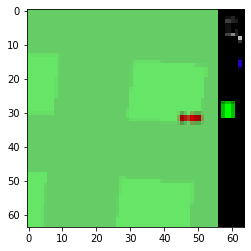

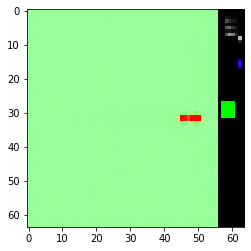

Training batch-1..
Training batch-2..
Training batch-3..
Training batch-4..
Training batch-5..
Training batch-6..
Training batch-7..
Training batch-8..
Training batch-9..
Training batch-10..
Training batch-11..
Training batch-12..
Training batch-13..
Training batch-14..
Training batch-15..
Training batch-16..
Training batch-17..
Training batch-18..
Training batch-19..
Training batch-20..
Training batch-21..
Training batch-22..
Training batch-23..
Training batch-24..
Training batch-25..
Training batch-26..
Training batch-27..
Training batch-28..
Training batch-29..
Training batch-30..
Training batch-31..
Training batch-32..
Training batch-33..
Training batch-34..
Training batch-35..
Training batch-36..
Training batch-37..
Training batch-38..
Training batch-39..
Training batch-40..
Training batch-41..
Training batch-42..
Training batch-43..
Training batch-44..
Training batch-45..
Training batch-46..
Training batch-47..
Training batch-48..
Training batch-49..
Training batch-50..
Training 

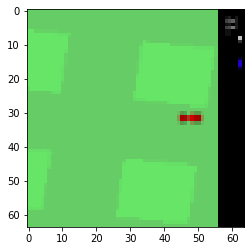

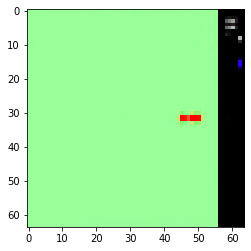

Training batch-1..
Training batch-2..
Training batch-3..
Training batch-4..
Training batch-5..
Training batch-6..
Training batch-7..
Training batch-8..
Training batch-9..
Training batch-10..
Training batch-11..
Training batch-12..
Training batch-13..
Training batch-14..
Training batch-15..
Training batch-16..
Training batch-17..
Training batch-18..
Training batch-19..
Training batch-20..
Training batch-21..
Training batch-22..
Training batch-23..
Training batch-24..
Training batch-25..
Training batch-26..
Training batch-27..
Training batch-28..
Training batch-29..
Training batch-30..
Training batch-31..
Training batch-32..
Training batch-33..
Training batch-34..
Training batch-35..
Training batch-36..
Training batch-37..
Training batch-38..
Training batch-39..
Training batch-40..
Training batch-41..
Training batch-42..
Training batch-43..
Training batch-44..
Training batch-45..
Training batch-46..
Training batch-47..
Training batch-48..
Training batch-49..
Training batch-50..
Training 

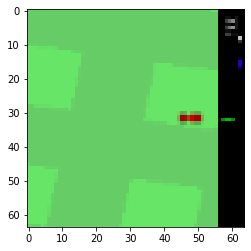

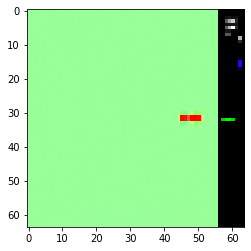

Training batch-1..
Training batch-2..
Training batch-3..
Training batch-4..
Training batch-5..
Training batch-6..
Training batch-7..
Training batch-8..
Training batch-9..
Training batch-10..
Training batch-11..
Training batch-12..
Training batch-13..
Training batch-14..
Training batch-15..
Training batch-16..
Training batch-17..
Training batch-18..
Training batch-19..
Training batch-20..
Training batch-21..
Training batch-22..
Training batch-23..
Training batch-24..
Training batch-25..
Training batch-26..
Training batch-27..
Training batch-28..
Training batch-29..
Training batch-30..
Training batch-31..
Training batch-32..
Training batch-33..
Training batch-34..
Training batch-35..
Training batch-36..
Training batch-37..
Training batch-38..
Training batch-39..
Training batch-40..
Training batch-41..
Training batch-42..
Training batch-43..
Training batch-44..
Training batch-45..
Training batch-46..
Training batch-47..
Training batch-48..
Training batch-49..
Training batch-50..
Training 

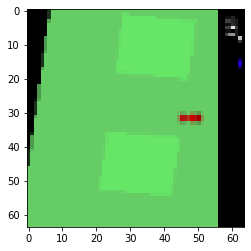

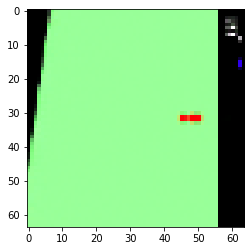

Training batch-1..
Training batch-2..
Training batch-3..
Training batch-4..
Training batch-5..
Training batch-6..
Training batch-7..
Training batch-8..
Training batch-9..
Training batch-10..
Training batch-11..
Training batch-12..
Training batch-13..
Training batch-14..
Training batch-15..
Training batch-16..
Training batch-17..
Training batch-18..
Training batch-19..
Training batch-20..
Training batch-21..
Training batch-22..
Training batch-23..
Training batch-24..
Training batch-25..
Training batch-26..
Training batch-27..
Training batch-28..
Training batch-29..
Training batch-30..
Training batch-31..
Training batch-32..
Training batch-33..
Training batch-34..
Training batch-35..
Training batch-36..
Training batch-37..
Training batch-38..
Training batch-39..
Training batch-40..
Training batch-41..
Training batch-42..
Training batch-43..
Training batch-44..
Training batch-45..
Training batch-46..
Training batch-47..
Training batch-48..
Training batch-49..
Training batch-50..
Training 

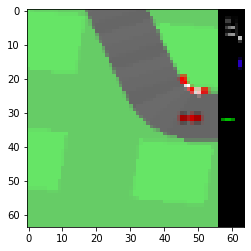

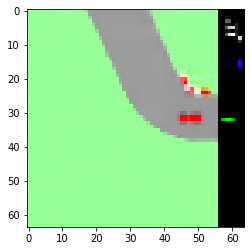

In [12]:
# Training
from torch.utils.data import DataLoader
from torchvision import transforms

tensorize = transforms.Compose([transforms.ToTensor(),])

data_dir = "../../../../../media/piyush/New Volume/dataset/"
NUM_FILES = len(os.listdir(data_dir))
NUM_TRAIN_FILES = NUM_FILES * 80 // 100
NUM_VAL_FILES = NUM_FILES - NUM_TRAIN_FILES
NUM_EPOCHS = 5
NUM_WORKERS = 8
BATCH_SIZE = 512
stats = {
    "train_loss":[],
    "val_loss":[]
}

for epoch in range(NUM_EPOCHS):
    # In an epoch
    train_loss = 0
    val_loss = 0
    for file_number in range(1, NUM_TRAIN_FILES + 1):
        # For *.npy files
        print("Training batch-{}..".format(file_number))
        
        # Prepare dataset
        filename = data_dir + "batch-{}.npy".format(file_number)
        data = np.load(filename, allow_pickle=True)
        data = np.vstack((data[0], data[1], data[2], data[3]))
        data_set = CarRacingDataset(data, transform=tensorize)
        data_loader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
        NUM_TRAIN_BATCHES = len(data_loader)
        
        for observation in data_loader:
            # Training VAE
            optim.zero_grad()
            
            observation = observation.to(device)
            observation_gen = vae(observation)
            
            loss = Loss(observation, observation_gen).to(device)
            loss.backward()
            optim.step()
            train_loss += loss.item()

    vae = vae.eval()
    for file_number in range(NUM_TRAIN_FILES + 1, NUM_FILES + 1):
        # For *.npy files
        print("Validating batch-{}..".format(file_number))
        
        # Prepare dataset
        filename = data_dir + "batch-{}.npy".format(file_number)
        data = np.load(filename, allow_pickle=True)
        data = np.vstack((data[0], data[1], data[2], data[3]))
        data_set = CarRacingDataset(data, transform=tensorize)
        data_loader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
        NUM_VAL_BATCHES = len(data_loader)
        
        for observation in data_loader:
            # Validating VAE
            observation = observation.to(device)
            observation_gen = vae(observation)
            
            loss = Loss(observation, observation_gen)
            val_loss += loss.item()

    vae = vae.train()

    stats["train_loss"].append(train_loss/NUM_TRAIN_BATCHES)
    stats["val_loss"].append(val_loss/NUM_VAL_BATCHES)
    print("Epoch {}: train_loss: {} val_loss: {}".format(
        epoch + 1, stats["train_loss"][-1], stats["val_loss"][-1]))
    show_image(iter(data_loader).next()[np.random.randint(0, 64)])
plot_losses(stats)        

In [13]:
torch.save(encoder, 'models/encoder-five-epochs.pt')
torch.save(decoder, 'models/decoder-five-epochs.pt')
torch.save(vae, 'models/vae-five-epochs.pt')